In [1]:
import warnings
warnings.filterwarnings('ignore')

MNIST 손글씨 데이터셋을 사용해 단일 모델들을 앙상블해서 투표를 통해 예측해본다

In [2]:
from sklearn import datasets # MNIST 손글씨 데이터셋을 사용하기 위해 import 시킨다.
from sklearn import tree # 의사결정 트리
from sklearn.neighbors import KNeighborsClassifier # kNN
from sklearn.svm import SVC # SVM
from sklearn.ensemble import VotingClassifier # 하드 보팅, 소프트 보팅을 계산한다.
from sklearn.model_selection import train_test_split # 학습, 검증 데이터 분리
from sklearn.metrics import accuracy_score # 정확도 계산

손글씨 데이터를 불러온다.

In [3]:
mnist = datasets.load_digits()
features, labels = mnist.data, mnist.target
print(features.shape, labels.shape)

(1797, 64) (1797,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
print('학습 데이터 개수: {}, 테스트 데이터 개수: {}'.format(len(X_train), len(X_test)))

학습 데이터 개수: 1437, 테스트 데이터 개수: 360


단일 모델의 정확도 측정  
앙상블의 정확도를 측정하기에 앞서 단일 모델들의 정확도를 의사결정 트리, kNN, SVM 분류기를 만들어 정확도를 계산한다.

In [5]:
# 의사결정 트리
# criterion : split 할 특성 선택 알고리즘
#     => gini : 지니 계수(gini index, 불순도, 집합에 이질적인 것이 얼마나 섞였는가), CART 알고리즘
#     => entropy : 엔트로피(entropy, 복잡도, 불확실성), ID3 알고리즘
# max_depth : 트리의 최대 깊이
# max_features : split 할 때 마다 랜덤으로 선택해 그 중 하나를 split 하는데 사용
# max_leaf_nodes : 최대 몇개 leaf 노드가 만들어 질때 까지 split 할 것인가, 작을수록 가지치기
# min_samples_split : 자식 노드를 가지기 위한 최소한의 데이터 개수
# min_samples_leaf : 리프 노드의 최소 데이터 개수
dtree = tree.DecisionTreeClassifier(criterion='gini', max_depth=8, max_features=32, random_state=35)
dtree = dtree.fit(X_train, y_train)
dtree_predicted = dtree.predict(X_test)

# kNN
# KNeighborsClassifier() 함수의 n_neighbors 속성에 kNN 모델에서 사용할 이웃의 개수를 지정한다.
knn = KNeighborsClassifier(n_neighbors=299).fit(X_train, y_train)
knn_predicted = knn.predict(X_test)

# SVM
# probability : 확률 추정치를 사용할지 여부를 지정한다. fit() 메소드를 호출하기 전에 저장해야 하며 실행 속도가 느려진다.
svm = SVC(C=0.1, gamma=0.003, probability=True, random_state=35).fit(X_train, y_train)
svm_predicted = svm.predict(X_test)

# 모델 예측 정확도(accuracy)를 출력한다.
print('정확도')
print('dtree: {}'.format(accuracy_score(y_test, dtree_predicted))) # 테스트 데이터 실제값, 예측값
print('knn:   {}'.format(accuracy_score(y_test, knn_predicted)))
print('svm:   {}'.format(accuracy_score(y_test, svm_predicted)))

정확도
dtree: 0.8
knn:   0.8694444444444445
svm:   0.9027777777777778


확률 합계

In [6]:
svm_proba = svm.predict_proba(X_test)
# print(len(svm_proba)) # 테스트 데이터 개수
print(svm_proba[0])
total = 0.0
for i in svm_proba[0]:
    total += i
print('확률 합계: {}'.format(total))

[1.02265489e-03 1.69863482e-03 3.66529238e-03 1.31529187e-03
 2.11912311e-03 4.85669481e-03 8.83226625e-04 9.75017181e-01
 5.84402918e-03 3.57787139e-03]
확률 합계: 0.9999999999999997


하드 보팅, 소프트 보팅은 VotingClassifier를 사용해 쉽게 구현할 수 있다.

하드 보팅  
하드 보팅은 일반적인 투표와 같이 각 분류기의 예측값들을 모아 가장 많은 투표를 받은 예측값으로 최종 결론을 내리는 방식이다.

In [7]:
voting_clf = VotingClassifier(estimators=[('decision_tree', dtree), ('knn', knn), ('svm', svm)], weights=[1, 1, 1],
                             voting='hard').fit(X_train, y_train)
hard_voting_predicted = voting_clf.predict(X_test)
print('hard_voting:   {}'.format(accuracy_score(y_test, hard_voting_predicted)))

hard_voting:   0.9138888888888889


소프트 보팅

In [8]:
voting_clf = VotingClassifier(estimators=[('decision_tree', dtree), ('knn', knn), ('svm', svm)], weights=[1, 1, 1],
                             voting='soft').fit(X_train, y_train)
soft_voting_predicted = voting_clf.predict(X_test)
print('soft_voting:   {}'.format(accuracy_score(y_test, soft_voting_predicted)))

soft_voting:   0.8916666666666667


단일 모델과 앙상블 모델의 정확도 비교 시각화

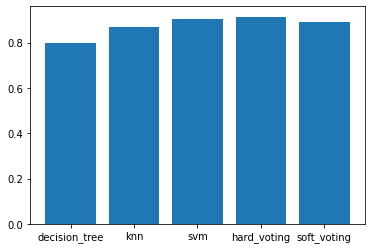

In [9]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.arange(5)
plt.bar(x, height=[
    accuracy_score(y_test, dtree_predicted),
    accuracy_score(y_test, knn_predicted),
    accuracy_score(y_test, svm_predicted),
    accuracy_score(y_test, hard_voting_predicted),
    accuracy_score(y_test, soft_voting_predicted)
])
plt.xticks(x, ['decision_tree', 'knn', 'svm', 'hard_voting', 'soft_voting'])
plt.show()